## Pipelines and Transformers

**<font color="red">EXPERIMENTAL! To use, please checkout the pipelines branch</font>**

```
git checkout pipelines
```

This notebook is part of the `ML Challenges for Streaming Data Hands-On Tutorial` (ECML'24) and contains some basics for Pipelines using CapyMOA.
* Basic pipeline configuration
* How to compose pipelines
* How to use pipelines as classifiers and regressors
* How to configure drift detection
* How to define custom pipeline elements

---

### CapyMOA 

* More information about CapyMOA can be found in: [https://github.com/adaptive-machine-learning/CapyMOA](https://github.com/adaptive-machine-learning/CapyMOA)

* _If you find CapyMOA useful, considering starring the project and joining the Discord channel!_

* **ECML 2024 tutorial ([homepage](https://heymarco.github.io/ecml24-streamingchallenges/))** by [Heitor Murilo Gomes](https://heitorgomes.com/), [Marco Heyden](https://heymarco.github.io/) and [Maroua Bahri](https://sites.google.com/site/bahrimarouaa/home). Vilnius, Lithuania (09/09/2024).


### Class Diagram

<p align="center">
  <img src="./images/pipelines.png" alt="alt text" width=100%/>
</p>


## 1. Running onlineBagging without any preprocessing

First, let us have a look at a simple test-then-train classification example without pipelines. 
- We loop over the instances of the data stream
- make a prediction,
- update the evaluator with the prediction and label
- and then train the classifier on the instance.

In [1]:
## Test-then-train loop
from capymoa.stream.preprocessing import MOATransformer
from capymoa.datasets import Electricity
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import ClassificationEvaluator

from moa.streams.filters import NormalisationFilter, ReplacingMissingValuesFilter


# Opening a file as a stream
elec_stream = Electricity()

# Creating the transformers
missing_values_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=ReplacingMissingValuesFilter())
normalisation_transformer = MOATransformer(schema=missing_values_transformer.get_schema(), moa_filter=NormalisationFilter())

# Creating a learner
ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    # get instance
    instance = elec_stream.next_instance()
    
    # transform instance
    transformed_instance = missing_values_transformer.transform_instance(instance)
    transformed_instance = normalisation_transformer.transform_instance(transformed_instance)

    # make prediction
    prediction = ob_learner.predict(transformed_instance)
    
    # update metric
    ob_evaluator.update(transformed_instance.y_index, prediction)
    
    # train
    ob_learner.train(transformed_instance)

ob_evaluator.accuracy()

80.53937146892656

## 2. Transforming instances using pipelines

If we want to perform some preprocessing, such as normalization or feature transformation, or a combination of both, we can chain multiple `Transformer`s within a pipeline. The most basic pipeline class `BasePipeline` already supports this.

In [2]:
from capymoa.stream.preprocessing import MOATransformer
from capymoa.stream.preprocessing import BasePipeline
from capymoa.stream import Stream
from moa.streams.filters import NormalisationFilter, ReplacingMissingValuesFilter
from moa.streams import FilteredStream

elec_stream = Electricity()

# Creating the transformers
missing_values_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=ReplacingMissingValuesFilter())
normalisation_transformer = MOATransformer(schema=missing_values_transformer.get_schema(), moa_filter=NormalisationFilter())

# Creating and populating the pipeline
preprocessing_pipeline = BasePipeline()
print(preprocessing_pipeline)

# Add the transformers to the pipeline. We can change the calls to add_transformer, as they return self
preprocessing_pipeline = (preprocessing_pipeline
                          .add_transformer(missing_values_transformer)
                          .add_transformer(normalisation_transformer)
                         )

# Creating a learner
ob_learner = OnlineBagging(schema=normalisation_transformer.get_schema(), ensemble_size=5)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=normalisation_transformer.get_schema()) 

while elec_stream.has_more_instances():
    # get instance
    instance = elec_stream.next_instance()

    # run preprocessing
    transformed_instance = preprocessing_pipeline.pass_forward(instance)
    
    # make prediction
    prediction = ob_learner.predict(transformed_instance)
    
    # update metric
    ob_evaluator.update(transformed_instance.y_index, prediction)
    
    # train
    ob_learner.train(transformed_instance)

ob_evaluator.accuracy()

80.53937146892656

## 2. Online Bagging using pipelines and transformers

Similar as classifiers, a `ClassifierPipeline` supports `train` and `predict`. Hence, we can use it in the same way as we would use other capymoa classifiers. 

- When calling `train`, the pipeline object internally calls `pass_forward` on all elements.
- When calling `predict`, the pipeline object internally calls `pass_forward_predict` on all elements and then returns the resulting prediction.

In [3]:
from capymoa.stream.preprocessing import MOATransformer
from capymoa.stream.preprocessing import ClassifierPipeline
from capymoa.stream import Stream
from moa.streams.filters import NormalisationFilter, ReplacingMissingValuesFilter
from moa.streams import FilteredStream

elec_stream = Electricity()

# Creating the transformers
missing_values_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=ReplacingMissingValuesFilter())
normalisation_transformer = MOATransformer(schema=missing_values_transformer.get_schema(), moa_filter=NormalisationFilter())

# Creating a learner
ob_learner = OnlineBagging(schema=normalisation_transformer.get_schema(), ensemble_size=5)

# Creating and populating the pipeline
pipeline = (ClassifierPipeline()
            .add_transformer(missing_values_transformer)
            .add_transformer(normalisation_transformer)
            .add_classifier(ob_learner))

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema()) 

while elec_stream.has_more_instances():
    # get instance
    instance = elec_stream.next_instance()

    # use pipeline to make prediction
    prediction = pipeline.predict(instance)

    # update metric
    ob_evaluator.update(instance.y_index, prediction)

    # train pipeline
    pipeline.train(instance)

ob_evaluator.accuracy()

80.53937146892656

We can also get a textual representation of the pipeline:

In [4]:
str(pipeline)

'PE(Transformer(ReplacingMissingValuesFilter)) | PE(Transformer(NormalisationFilter)) | PE(OnlineBagging) | '

## 3. RegressorPipeline

The regression version of the pipeline is analogous to the classification one

In [5]:
from capymoa.regressor import AdaptiveRandomForestRegressor
from capymoa.stream.preprocessing import RegressorPipeline
from capymoa.evaluation import RegressionEvaluator
from capymoa.datasets import Fried

fried_stream = Fried()

# Create the transformers
missing_values_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=ReplacingMissingValuesFilter())
normalisation_transformer = MOATransformer(schema=fried_stream.get_schema(), moa_filter=NormalisationFilter())

arfreg = AdaptiveRandomForestRegressor(schema=normalisation_transformer.get_schema(), ensemble_size=5)

# Creating and populating the pipeline
pipeline_arfreg = (RegressorPipeline()
                   .add_transformer(missing_values_transformer)
                   .add_transformer(normalisation_transformer)
                   .add_regressor(arfreg)
                  )

# Creating the evaluator
arfreg_evaluator = RegressionEvaluator(schema=fried_stream.get_schema()) 

while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = pipeline_arfreg.predict(instance)
    arfreg_evaluator.update(instance.y_value, prediction)
    pipeline_arfreg.train(instance)

print(f"RMSE = {round(arfreg_evaluator.rmse(), 2)}")

RMSE = 2.58


## 4. Drift Detection

We now showcase the use of drift detectors in pipelines with two small examples
1. Drift detector accuracy
2. Drift detector monitors first input feature

### 4.1 Monitoring classifier accuracy

In [6]:
from capymoa.drift.detectors import ADWIN
from capymoa.instance import LabeledInstance
from capymoa.type_alias import LabelIndex
from capymoa.stream.preprocessing import MOATransformer
from capymoa.stream.preprocessing import ClassifierPipeline
from capymoa.stream import Stream
from moa.streams.filters import NormalisationFilter, ReplacingMissingValuesFilter
from moa.streams import FilteredStream

elec_stream = Electricity()

# Creating the transformers
missing_values_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=ReplacingMissingValuesFilter())
normalisation_transformer = MOATransformer(schema=missing_values_transformer.get_schema(), moa_filter=NormalisationFilter())

# Creating a learner
ob_learner = OnlineBagging(schema=normalisation_transformer.get_schema(), ensemble_size=5)

# Creating a drift detector
drift_detector = ADWIN()

# Define a function that prepares the input of the drift detector
def label_equals_prediction(instance: LabeledInstance, prediction: LabelIndex) -> LabelIndex:
    label = instance.y_index
    return int(label == prediction)

# Creating and populating the pipeline
pipeline = (ClassifierPipeline()
            .add_transformer(missing_values_transformer)
            .add_transformer(normalisation_transformer)
            .add_classifier(ob_learner)
            .add_drift_detector(drift_detector, get_drift_detector_input_func=label_equals_prediction))

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema()) 

i = 0
while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = pipeline.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    pipeline.train(instance)
    if drift_detector.detected_change():
        print(f"Detected change at index {i}")
    i += 1

print(f"Accuracy = {round(ob_evaluator.accuracy(), 2)}")

Detected change at index 3039
Detected change at index 5535
Detected change at index 9183
Detected change at index 9215
Detected change at index 9535
Detected change at index 9599
Detected change at index 12415
Detected change at index 13023
Detected change at index 13183
Detected change at index 16031
Detected change at index 18143
Detected change at index 18815
Detected change at index 18879
Detected change at index 19263
Detected change at index 21407
Detected change at index 21503
Detected change at index 23775
Detected change at index 24095
Detected change at index 24127
Detected change at index 24959
Detected change at index 24991
Detected change at index 26143
Detected change at index 27711
Detected change at index 28191
Detected change at index 29407
Detected change at index 29471
Detected change at index 29535
Detected change at index 31487
Detected change at index 31551
Detected change at index 33919
Detected change at index 35391
Detected change at index 35423
Detected chang

### 4.2 Unsupervised drift detection

For the sake of illustration, this example is very simple. However, one can easily think of more complex use cases of `get_drift_detector_input_func`. One can provide any object that implements `__call__(instance, prediction)`. For example, one could provide a class that monitors the correlation between a set of input features.

In this example, we simply monitor the first input feature

In [7]:
from capymoa.drift.detectors import ADWIN
from capymoa.instance import LabeledInstance
from capymoa.type_alias import LabelIndex
from moa.streams.filters import NormalisationFilter, ReplacingMissingValuesFilter
from moa.streams import FilteredStream

elec_stream = Electricity()

# Create the transformers
missing_values_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=ReplacingMissingValuesFilter())
normalisation_transformer = MOATransformer(schema=missing_values_transformer.get_schema(), moa_filter=NormalisationFilter())

# Create a learner
ob_learner = OnlineBagging(schema=normalisation_transformer.get_schema(), ensemble_size=5)

# Create a drift detector
class FeatureMonitor:
    def __init__(self, feature: int):
        self.feature = feature
        
    """
    Here we could of course implement a much more sophisticated logic
    ...
    """
    
    def __call__(self, instance: LabeledInstance, prediction: LabelIndex) -> LabelIndex:
        feature_val = instance.x[self.feature]
        return int(feature_val > 0.0)
        
drift_detector = ADWIN()
feature_monitor = FeatureMonitor(feature=0)

# Creating and populating the pipeline
pipeline = (ClassifierPipeline()
            .add_drift_detector(drift_detector, get_drift_detector_input_func=feature_monitor)
            .add_transformer(missing_values_transformer)
            .add_transformer(normalisation_transformer) 
            .add_classifier(ob_learner)
           )

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema()) 

i = 0
while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = pipeline.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    pipeline.train(instance)
    if drift_detector.detected_change():
        print(f"Detected change at index {i}")
    i += 1

print(f"Accuracy = {round(ob_evaluator.accuracy(), 2)}")

Detected change at index 95
Detected change at index 159
Accuracy = 80.54


## 5. Pipelines within pipelines

In [8]:
from capymoa.drift.detectors import ADWIN
from capymoa.instance import LabeledInstance
from capymoa.type_alias import LabelIndex
from moa.streams.filters import NormalisationFilter, ReplacingMissingValuesFilter
from moa.streams import FilteredStream

elec_stream = Electricity()

# Creating the transformers
missing_values_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=ReplacingMissingValuesFilter())
normalisation_transformer = MOATransformer(schema=missing_values_transformer.get_schema(), moa_filter=NormalisationFilter())

# Creating a learner
ob_learner = OnlineBagging(schema=normalisation_transformer.get_schema(), ensemble_size=5)

# Creating a drift detector
drift_detector = ADWIN()

# Define a function that prepares the input of the drift detector
def label_equals_prediction(instance: LabeledInstance, prediction: LabelIndex) -> LabelIndex:
    label = instance.y_index
    return int(label == prediction)

# Creating and populating the transformation pipeline
trafo_pipeline = (BasePipeline()
                  .add_transformer(missing_values_transformer)
                  .add_transformer(normalisation_transformer)
                 )

# Creating and populating the prediction pipeline
prediction_pipeline = ClassifierPipeline().add_classifier(ob_learner)

# Creating and populating the drift detection pipeline
drift_pipeline = BasePipeline().add_drift_detector(drift_detector, get_drift_detector_input_func=label_equals_prediction)

# Setting up the final pipeline
pipeline = (ClassifierPipeline()
            .add_pipeline_element(trafo_pipeline)
            .add_pipeline_element(prediction_pipeline)
            .add_pipeline_element(drift_pipeline))

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema()) 

i = 0
while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = pipeline.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    pipeline.train(instance)
    if drift_detector.detected_change():
        print(f"Detected change at index {i}")
    i += 1

print(f"Accuracy = {round(ob_evaluator.accuracy(), 2)}")

Detected change at index 3039
Detected change at index 5535
Detected change at index 9183
Detected change at index 9215
Detected change at index 9535
Detected change at index 9599
Detected change at index 12415
Detected change at index 13023
Detected change at index 13183
Detected change at index 16031
Detected change at index 18143
Detected change at index 18815
Detected change at index 18879
Detected change at index 19263
Detected change at index 21407
Detected change at index 21503
Detected change at index 23775
Detected change at index 24095
Detected change at index 24127
Detected change at index 24959
Detected change at index 24991
Detected change at index 26143
Detected change at index 27711
Detected change at index 28191
Detected change at index 29407
Detected change at index 29471
Detected change at index 29535
Detected change at index 31487
Detected change at index 31551
Detected change at index 33919
Detected change at index 35391
Detected change at index 35423
Detected chang

# Defining custom pipeline elements
## Random Search

In [9]:
from typing import Optional, List, Protocol, Tuple, Any, Callable
import numpy as np
from capymoa.base import Classifier
from capymoa.stream.preprocessing import ClassifierPipelineElement
from capymoa.type_alias import LabelProbabilities, LabelIndex, TargetValue
from capymoa.instance import LabeledInstance, Instance, RegressionInstance

class RandomSearchClassifierPE(ClassifierPipelineElement, Classifier):
    def __init__(self,
                 classifier_class: Classifier,
                 hyperparameter_ranges: dict,
                 n_combinations: int,
                 rng: np.random.Generator):
        
        # initialize the pipeline element but don't specify a learner
        super(RandomSearchClassifierPE, self).__init__(learner=None)

        # assign the variables from the initializer
        self.classifier_class = classifier_class
        self.hyperparameter_ranges = hyperparameter_ranges
        self.n_combinations = n_combinations
        self.rng = rng

        # sample n_combinations of hyperparameters
        self.hyperparameters = []
        for _ in range(n_combinations):
            hp_combination = {
                hp_name: rng.choice(values) for hp_name, values in hyperparameter_ranges.items()
            }
            self.hyperparameters.append(hp_combination)

        # instantiate models
        self.models = [self.classifier_class(**hp_kwargs) for hp_kwargs in self.hyperparameters]
        self.model_accuracy = [0.0 for _ in range(len(self.models))]
        self.seen_instances = 0

    def __str__(self):
        return f"RandomSearch({str(self.classifier_class.__name__)})"

    def pass_forward(self, instance: LabeledInstance) -> Instance:
        # loop through all models, update their accuracy, and train them
        for model_idx, model in enumerate(self.models):
            y_hat = model.predict(instance)

            correct = int(y_hat == instance.y_index)
            old_acc = self.model_accuracy[model_idx]
            new_acc = (old_acc * self.seen_instances + correct) / (self.seen_instances + 1)
            self.model_accuracy[model_idx] = new_acc

            model.train(instance)
        self.seen_instances += 1
        return instance

    def pass_forward_predict(self, instance: Instance, prediction=None) -> Tuple[Instance, Any]:
        # find the best model, let it do the prediction
        best_model_idx = np.argmax(self.model_accuracy)
        best_model = self.models[best_model_idx]
        return instance, best_model.predict(instance)

    def train(self, instance: LabeledInstance):
        self.pass_forward(instance)
        return self

    def predict(self, instance: Instance) -> Optional[LabelIndex]:
        inst, pred = self.pass_forward_predict(instance)
        return pred

    def predict_proba(self, instance: Instance) -> LabelProbabilities:
        raise NotImplementedError


In [10]:
import numpy as np
from capymoa.classifier import HoeffdingTree
from capymoa.stream.preprocessing import TransformerPipelineElement

elec_stream = Electricity()
normalisation_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=NormalisationFilter())

ht_pipeline_element = ClassifierPipelineElement(HoeffdingTree(elec_stream.get_schema()))
ht_pipeline = ClassifierPipeline([TransformerPipelineElement(normalisation_transformer), ht_pipeline_element])

classifier_class = HoeffdingTree

hyperparameter_ranges = {
    "schema": [elec_stream.get_schema()],
    "grace_period": [1, 50, 100, 200, 500],
    "split_criterion": ["InfoGainSplitCriterion", "GiniSplitCriterion"],
    "confidence": [10.0 ** (-i) for i in range(1, 5)],
    "tie_threshold": [0.05, 0.03, 0.01, 0.001]
}

rng = np.random.default_rng(0)
n_combinations = 50

random_search_pe = RandomSearchClassifierPE(classifier_class, hyperparameter_ranges, n_combinations, rng)
normalisation_transformer = MOATransformer(schema=elec_stream.get_schema(), moa_filter=NormalisationFilter())

rs_pipeline = ClassifierPipeline([TransformerPipelineElement(normalisation_transformer), random_search_pe])

PE(Transformer(NormalisationFilter)) | PE(HoeffdingTree) |  [cumulative] Accuracy = 78.954802259887
PE(Transformer(NormalisationFilter)) | RandomSearch(HoeffdingTree) |   [cumulative] Accuracy = 80.89909957627118


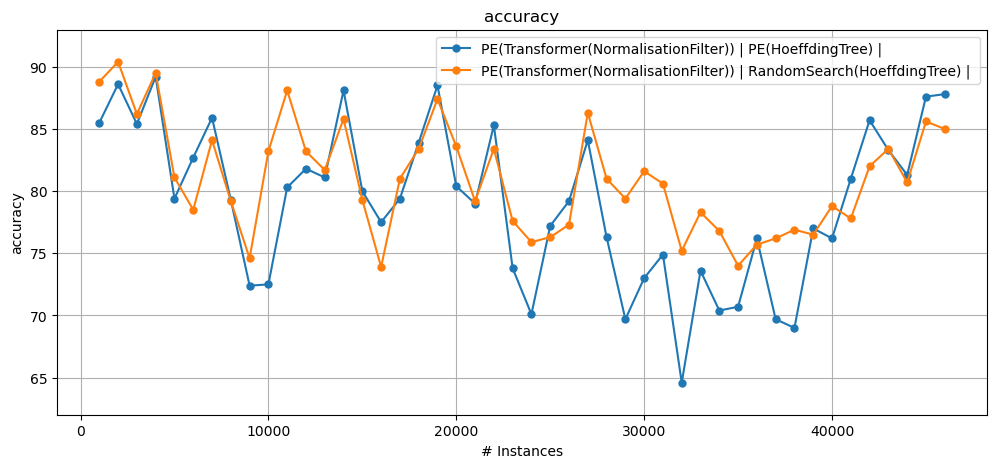

In [11]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation

ht_results = prequential_evaluation(stream=elec_stream, learner=ht_pipeline, window_size=1000)
rs_results = prequential_evaluation(stream=elec_stream, learner=rs_pipeline, window_size=1000)

print(f"{ht_results['learner']} [cumulative] Accuracy = {ht_results['cumulative'].accuracy()}")
print(f"{rs_results['learner']}  [cumulative] Accuracy = {rs_results['cumulative'].accuracy()}")

plot_windowed_results(ht_results, rs_results, metric="accuracy", figure_path=None)